# Traitement des Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
dataframe_brute = pd.read_csv(r'C:\Users\jacqu\Scolarite\M2A\RLD\TME1\CTR.txt', sep="\s+|;|:", header=None, engine = 'python')
dataframe_brute.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0,0.748371,0.835208,0.076699,0.172439,0.143446,0.103419,0.190698,0.0,0.102401,0.036312,0.074562,0.234702,0.000000,0.000000,0.078574
1,1,0.168419,0.133754,0.434864,0.995678,0.048800,0.000000,0.000000,0.0,0.020827,0.000000,0.000000,0.022586,0.000000,0.146548,0.324596
2,2,0.485287,0.566989,0.041657,0.962560,0.185080,0.109575,0.136626,0.0,0.098411,0.074771,0.000000,0.000000,0.000000,0.014760,0.193677
3,3,0.622231,0.196123,0.131147,0.439719,0.298934,0.000000,0.151069,0.0,0.127239,0.112239,0.000000,0.012022,0.034284,0.000000,0.086177
4,4,0.331710,0.086411,0.023036,0.925518,0.333580,0.000000,0.109214,0.0,0.151938,0.049861,0.000000,0.000000,0.037427,0.118916,0.216592


In [3]:
#Je me suis inspiré de Théophile Cantelobre pour comprendre ce qu'étaient des classes

class Data:
    def __init__(self, dataframe):
        self.gains = np.array(dataframe.loc[:, 6:])
        self.context = np.array(dataframe.loc[:, 1:6])
        self.cur = 0 
        self.N = dataframe.shape[0]
    
    def get(self, i):
        return self.context[i], self.gains[i], np.max(self.gains[i])


In [4]:
dataframe_finale = Data(dataframe_brute)

# Baselines

## Algorithme Random, Algorithme StaticBest

In [5]:
# On veut afficher ici le regret le long de la dataframe : ie la stratégie optimale - la stratégie utilisée

def random_baseline(dataframe):
    N = dataframe.N
    regret = np.zeros(N)
    for i in range(N):
        c, g, mx = dataframe.get(i)
        gain = np.random.choice(g)
        regret[i] = mx - gain
    return regret
    
    
def static_best_baseline(dataframe):
    N = dataframe.N
    regret = np.zeros(N)
    best_gain_cum = np.zeros(10)
    for i in range(N):
        c, g, mx = dataframe.get(i)
        regret[i] = mx - g[np.argmax(best_gain_cum)]
        best_gain_cum += g
    return regret

def optimal(dataframe):
    N = dataframe.N
    opt = []
    for i in range(N):
        c, g , mx = dataframe.get(i)
        opt.append(mx)
    return opt
        

In [6]:
opt = optimal(dataframe_finale)
random_regret = random_baseline(dataframe_finale)
static_best_regret = static_best_baseline(dataframe_finale)

## Algorithme des Bandits

In [7]:
def ucb(dataframe):
    
    nombre_bras= dataframe.gains.shape[1]
    N = dataframe.N
    regret = np.zeros(N)
    #Variables pour l'algo ucb:
    L = np.arange(nombre_bras)
    liste_choix = []
    actions_count = np.ones(nombre_bras)
    values_means = np.zeros(nombre_bras)
    #et c'est parti
    for t in range(N):
        c, g, mx = dataframe.get(t)
        
        intervalle_optimi = [values_means[k] + np.sqrt(2 * np.log (t+1) / (actions_count[k]) ) for k in L ]
        choix = np.argmax(intervalle_optimi)
        
        actions_count[choix] += 1
        values_means[choix] = (actions_count[choix] * values_means[choix] + g[choix] ) / (actions_count[choix] + 1) 
        
        liste_choix.append(choix)
        regret[t] = mx - g[choix] 
    return(regret)

ucb_regret = ucb(dataframe_finale)

In [8]:
def ucb_v(dataframe): #Problème de complexité dans mon code : je refais tout le calcul des variances alors qu'il faudrait les update 1 à 1...
    
    nombre_bras= dataframe.gains.shape[1]
    N = dataframe.N
    regret = np.zeros(N)
    #Variables pour l'algo ucb_v:
    L = np.arange(nombre_bras)
    liste_choix = []
    valeur_choix = []
    actions_count = np.ones(nombre_bras)
    values_means = np.zeros(nombre_bras)
    values_variance = np.zeros(nombre_bras)

    
    #et c'est parti
    for t in range(N):
        c, g, mx = dataframe.get(t)
        
        for k in L:
            values_variance[k] = 1/(t+1) *( sum((valeur_choix - values_means[k]*np.ones(t))**2)) #le 
            
        
        
        intervalle_optimi = [values_means[k] + np.sqrt(2 * np.log (t+1) * values_variance[k] / (actions_count[k]) ) + np.log (t+1) / (2 * actions_count[k]) for k in L ]
        choix = np.argmax(intervalle_optimi)
        
        actions_count[choix] += 1
        values_means[choix] = (actions_count[choix] * values_means[choix] + g[choix] ) / (actions_count[choix] + 1) 
        liste_choix.append(choix)
        valeur_choix.append(g[choix])
        
        regret[t] = mx - g[choix] 
        
    return(regret)


ucb_v_regret = ucb_v(dataframe_finale)

In [9]:
def lin_ucb(dataframe, alpha = 0.1):
    
    nombre_bras= dataframe.gains.shape[1]
    nombre_contexte= dataframe.context.shape[1]
    N = dataframe.N
    regret = np.zeros(N)
    #parametres pour lin_ucb
    D = [np.identity(nombre_contexte) for k in range(nombre_bras)] 
    b = [np.zeros(nombre_contexte) for k in range(nombre_bras)]
    L = np.arange(nombre_bras) 
    compte = np.zeros(nombre_bras)
    
    for t in range(N):
        
        c, g, mx = dataframe.get(t)
        for k in L:
            theta_k = D[k] @ b[k]
            compte[k] = theta_k.T @ c + alpha * np.sqrt(c.T @ D[k] @ c) 
        choix = np.argmax(compte)
        regret[t] = mx - g[choix]
        
        #On update
        D_inv = np.linalg.inv(D[choix])
        D_inv = D_inv + c @ c.T
        D[choix] = np.linalg.inv(D_inv)
        b[choix] = b[choix] + g[choix] * c
        
        
    return(regret)
        
    
    
    
lin_ucb_regret = lin_ucb(dataframe_finale)
    
    

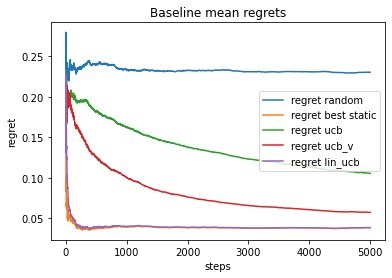

In [10]:
x = np.arange(dataframe_finale.N)
fig, ax = plt.subplots()
ax.plot(x, np.cumsum(random_regret) / np.arange(1,5001) , label="regret random")
ax.plot(x, np.cumsum(static_best_regret) / np.arange(1,5001), label="regret best static")
ax.plot(x, np.cumsum(ucb_regret) / np.arange(1,5001), label="regret ucb")
ax.plot(x, np.cumsum(ucb_v_regret) / np.arange(1,5001), label="regret ucb_v")
ax.plot(x, np.cumsum(lin_ucb_regret) / np.arange(1,5001), label="regret lin_ucb")
ax.set_title('Baseline mean regrets')
ax.set_xlabel('steps')
ax.set_ylabel('regret')
ax.legend(loc="best");

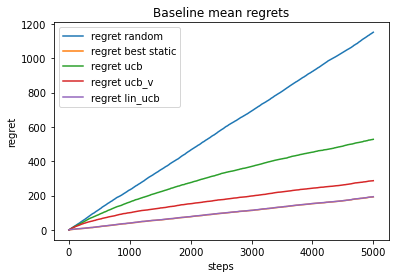

In [11]:
x = np.arange(dataframe_finale.N)
fig, ax = plt.subplots()
ax.plot(x, np.cumsum(random_regret) , label="regret random")
ax.plot(x, np.cumsum(static_best_regret), label="regret best static")
ax.plot(x, np.cumsum(ucb_regret), label="regret ucb")
ax.plot(x, np.cumsum(ucb_v_regret), label="regret ucb_v")
ax.plot(x, np.cumsum(lin_ucb_regret), label="regret lin_ucb")
ax.set_title('Baseline mean regrets')
ax.set_xlabel('steps')
ax.set_ylabel('regret')
ax.legend(loc="best");

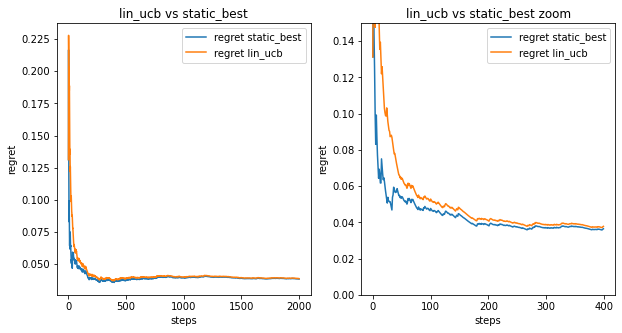

In [12]:
x = np.arange(2000)
t = np.arange(400)
fig, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(10, 5)) 


ax[0].plot(x, np.cumsum(static_best_regret[:2000]) / np.arange(1,2001), label="regret static_best")
ax[0].plot(x, np.cumsum(lin_ucb_regret[:2000]) / np.arange(1,2001), label="regret lin_ucb")

ax[0].set_title('lin_ucb vs static_best')
ax[0].set_xlabel('steps')
ax[0].set_ylabel('regret')
ax[0].legend(loc="best")

ax[1].plot(t, np.cumsum(static_best_regret[:400]) / np.arange(1,401), label="regret static_best")
ax[1].plot(t, np.cumsum(lin_ucb_regret[:400]) / np.arange(1,401), label="regret lin_ucb")

ax[1].set_ylim(0.0, 0.150)
ax[1].set_title('lin_ucb vs static_best zoom')
ax[1].set_xlabel('steps')
ax[1].set_ylabel('regret')
ax[1].legend(loc="best");